In [69]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# !pip install torchsummary
from torchsummary import summary

In [3]:
torch.manual_seed(1)
batch_size = 128
lr = 0.01
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

In [4]:
from tqdm import tqdm

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')


def test(model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_loss_arr.append(test_loss)
    accuracy_arr.append(100. * correct / len(test_loader.dataset))
    print('\nEpoch: {}, Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        epoch, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [268]:
# Conditions to meet:
# 99.4% validation accuracy
# Less than 20k Parameters
# Less than 20 Epochs

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.nn = nn.Sequential(
            nn.Conv2d(1, 16, 3),
                nn.ReLU(),
            nn.Conv2d(16, 16, 3),
                nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(16),
            
            nn.Conv2d(16, 32, 3),
                nn.ReLU(),
            nn.Conv2d(32, 32, 3),
                nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(32),
            
            nn.Conv2d(32, 10, 1),
            nn.AvgPool2d(4)
        )
#         self.fc1 = nn.Linear(32, 64)
#         self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.nn(x)
        x = x.view(-1, 10)
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
        return F.log_softmax(x)

In [269]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
              ReLU-2           [-1, 16, 26, 26]               0
            Conv2d-3           [-1, 16, 24, 24]           2,320
              ReLU-4           [-1, 16, 24, 24]               0
         MaxPool2d-5           [-1, 16, 12, 12]               0
       BatchNorm2d-6           [-1, 16, 12, 12]              32
            Conv2d-7           [-1, 32, 10, 10]           4,640
              ReLU-8           [-1, 32, 10, 10]               0
            Conv2d-9             [-1, 32, 8, 8]           9,248
             ReLU-10             [-1, 32, 8, 8]               0
        MaxPool2d-11             [-1, 32, 4, 4]               0
      BatchNorm2d-12             [-1, 32, 4, 4]              64
           Conv2d-13             [-1, 10, 4, 4]             330
        AvgPool2d-14             [-1, 1

C:\Users\focusedmonk\AppData\Local\Temp\ipykernel_30492\3819397167.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [270]:
### model = Net().to(device)
test_loss_arr = []
accuracy_arr = []
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
epochs = 20

for epoch in range(1, epochs+1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader, epoch)

  0%|                                                                                          | 0/469 [00:00<?, ?it/s]C:\Users\focusedmonk\AppData\Local\Temp\ipykernel_30492\3819397167.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
loss=0.08788618445396423 batch_id=468: 100%|█████████████████████████████████████████| 469/469 [00:23<00:00, 19.66it/s]



Epoch: 1, Test set: Average loss: 0.1281, Accuracy: 9670/10000 (96.700%)



loss=0.05853581428527832 batch_id=468: 100%|█████████████████████████████████████████| 469/469 [00:24<00:00, 19.01it/s]



Epoch: 2, Test set: Average loss: 0.0752, Accuracy: 9803/10000 (98.030%)



loss=0.06980551034212112 batch_id=468: 100%|█████████████████████████████████████████| 469/469 [00:24<00:00, 19.04it/s]



Epoch: 3, Test set: Average loss: 0.0789, Accuracy: 9786/10000 (97.860%)



loss=0.015073857270181179 batch_id=468: 100%|████████████████████████████████████████| 469/469 [00:24<00:00, 19.29it/s]



Epoch: 4, Test set: Average loss: 0.0446, Accuracy: 9885/10000 (98.850%)



loss=0.029951730743050575 batch_id=468: 100%|████████████████████████████████████████| 469/469 [00:24<00:00, 19.15it/s]



Epoch: 5, Test set: Average loss: 0.0428, Accuracy: 9876/10000 (98.760%)



loss=0.03985142707824707 batch_id=468: 100%|█████████████████████████████████████████| 469/469 [00:24<00:00, 19.44it/s]



Epoch: 6, Test set: Average loss: 0.0333, Accuracy: 9891/10000 (98.910%)



loss=0.03689432516694069 batch_id=468: 100%|█████████████████████████████████████████| 469/469 [00:23<00:00, 19.76it/s]



Epoch: 7, Test set: Average loss: 0.0330, Accuracy: 9899/10000 (98.990%)



loss=0.031182875856757164 batch_id=468: 100%|████████████████████████████████████████| 469/469 [00:23<00:00, 19.56it/s]



Epoch: 8, Test set: Average loss: 0.0343, Accuracy: 9893/10000 (98.930%)



loss=0.010159126482903957 batch_id=468: 100%|████████████████████████████████████████| 469/469 [00:24<00:00, 19.01it/s]



Epoch: 9, Test set: Average loss: 0.0307, Accuracy: 9904/10000 (99.040%)



loss=0.00812713336199522 batch_id=468: 100%|█████████████████████████████████████████| 469/469 [00:29<00:00, 16.00it/s]



Epoch: 10, Test set: Average loss: 0.0294, Accuracy: 9907/10000 (99.070%)



loss=0.024531280621886253 batch_id=468: 100%|████████████████████████████████████████| 469/469 [00:23<00:00, 19.90it/s]



Epoch: 11, Test set: Average loss: 0.0283, Accuracy: 9916/10000 (99.160%)



loss=0.016468504443764687 batch_id=468: 100%|████████████████████████████████████████| 469/469 [00:23<00:00, 19.90it/s]



Epoch: 12, Test set: Average loss: 0.0298, Accuracy: 9902/10000 (99.020%)



loss=0.019880743697285652 batch_id=468: 100%|████████████████████████████████████████| 469/469 [00:23<00:00, 19.98it/s]



Epoch: 13, Test set: Average loss: 0.0258, Accuracy: 9928/10000 (99.280%)



loss=0.004878502804785967 batch_id=468: 100%|████████████████████████████████████████| 469/469 [00:23<00:00, 19.76it/s]



Epoch: 14, Test set: Average loss: 0.0250, Accuracy: 9911/10000 (99.110%)



loss=0.011124434880912304 batch_id=468: 100%|████████████████████████████████████████| 469/469 [00:23<00:00, 19.87it/s]



Epoch: 15, Test set: Average loss: 0.0253, Accuracy: 9917/10000 (99.170%)



loss=0.014251972548663616 batch_id=468: 100%|████████████████████████████████████████| 469/469 [00:23<00:00, 19.94it/s]



Epoch: 16, Test set: Average loss: 0.0251, Accuracy: 9918/10000 (99.180%)



loss=0.012572293169796467 batch_id=468: 100%|████████████████████████████████████████| 469/469 [00:23<00:00, 19.93it/s]



Epoch: 17, Test set: Average loss: 0.0269, Accuracy: 9917/10000 (99.170%)



loss=0.00897615309804678 batch_id=468: 100%|█████████████████████████████████████████| 469/469 [00:23<00:00, 19.96it/s]



Epoch: 18, Test set: Average loss: 0.0236, Accuracy: 9923/10000 (99.230%)



loss=0.003649483434855938 batch_id=468: 100%|████████████████████████████████████████| 469/469 [00:23<00:00, 19.91it/s]



Epoch: 19, Test set: Average loss: 0.0235, Accuracy: 9924/10000 (99.240%)



loss=0.0032946632709354162 batch_id=468: 100%|███████████████████████████████████████| 469/469 [00:26<00:00, 17.37it/s]



Epoch: 20, Test set: Average loss: 0.0223, Accuracy: 9929/10000 (99.290%)



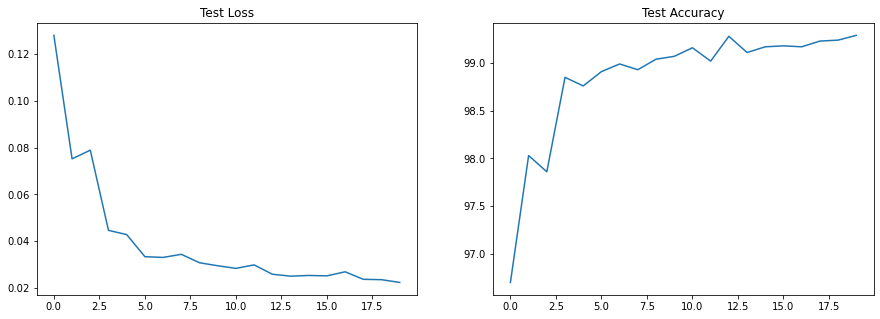

In [271]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(test_loss_arr)
plt.title('Test Loss')
plt.subplot(1, 2, 2)
plt.plot(accuracy_arr)
plt.title('Test Accuracy')
plt.show()